사전훈련된 네트워크에 의해 학습된 특성의 계층구조 >> 유연한 재사용으로 효율성 극대화

재사용 method
1. 특성 추출
2. 미세조정

Input -Convolutional base(Conv layers)-Classifier(Dense layers)-Output

일반적으로 Conv 층이 일반적인 표현을 학습하기 때문에 재사용에 용이
재사용 여부는 conv 층의 깊이가 주요 요인

keras 모듈에 포함된 모듈 종류

VGG16

Xception

Inception V3

ResNet50

In [2]:
from keras.applications import VGG16

conv_base =VGG16(weights ='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [9]:
import os,shutil

#original_dataset_dir='/content/train'

base_dir='cats_and_dogs_small'
# if os.path.exists(base_dir):
#   shutil.rmtree(base_dir)
# os.mkdir(base_dir)

train_dir= os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
validation_dir=os.path.join(base_dir,'validation')
#os.mkdir(validation_dir)
test_dir=os.path.join(base_dir,'test')
#os.mkdir(test_dir)

train_cats_dir=os.path.join(train_dir, 'cats')
#os.mkdir(train_cats_dir)
train_dogs_dir=os.path.join(train_dir,'dogs')
#os.mkdir(train_dogs_dir)

validation_cats_dir=os.path.join(validation_dir,'cats')
#os.mkdir(validation_cats_dir)
validation_dogs_dir=os.path.join(validation_dir,'dogs')
#os.mkdir(validation_dogs_dir)

test_cats_dir=os.path.join(test_dir,'cats')
#os.mkdir(test_cats_dir)
test_dogs_dir=os.path.join(test_dir,'dogs')
#os.mkdir(test_dogs_dir)

# fnames=['cat.{}.jpg'.format(i) for i in range(1000)]
# for fname in fnames:
#   src=os.path.join(original_dataset_dir, fname)
#   dst=os.path.join(train_cats_dir, fname)
#   shutil.copyfile(src,dst)


# fnames=['cat.{}.jpg'.format(i) for i in range(1000,1500)]
# for fname in fnames:
#   src=os.path.join(original_dataset_dir, fname)
#   dst=os.path.join(validation_cats_dir, fname)
#   shutil.copyfile(src,dst)


# fnames=['cat.{}.jpg'.format(i) for i in range(1500,2000)]
# for fname in fnames:
#   src=os.path.join(original_dataset_dir, fname)
#   dst=os.path.join(test_cats_dir, fname)
#   shutil.copyfile(src,dst)


# fnames=['dog.{}.jpg'.format(i) for i in range(1000)]
# for fname in fnames:
#   src=os.path.join(original_dataset_dir, fname)
#   dst=os.path.join(train_dogs_dir, fname)
#   shutil.copyfile(src,dst)

  
# fnames=['dog.{}.jpg'.format(i) for i in range(1000,1500)]
# for fname in fnames:
#   src=os.path.join(original_dataset_dir, fname)
#   dst=os.path.join(validation_dogs_dir, fname)
#   shutil.copyfile(src,dst)

  
# fnames=['dog.{}.jpg'.format(i) for i in range(1500,2000)]
# for fname in fnames:
#   src=os.path.join(original_dataset_dir, fname)
#   dst=os.path.join(test_dogs_dir, fname)
#   shutil.copyfile(src,dst)

In [10]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [11]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'cats_and_dogs_small'

train_dir= os.path.join(base_dir, 'train')
validation_dir=os.path.join(base_dir, 'validation')
test_dir=os.path.join(base_dir,'test')

datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

In [12]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels=np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch =conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+= 1
        if i*batch_size>=sample_count:
            break
    return features,labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labes =extract_features(validation_dir,1000)
test_features, test_labels=extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
train_features=np.reshape(train_features,(2000,4*4*512))
validation_features=np.reshape(validation_features,(1000,4*4*512))
test_features=np.reshape(test_features,(1000,4*4*512))
#dense layer에 연결하기 위해 flatten 작업
#여기서 4*4*512를 해야 8192 사이즈의 1차원 벡터가 될 텐데 3차원으로 넣어버림>>오류

In [14]:
validation_features.shape

(1000, 8192)

In [15]:
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history=model.fit(train_features,train_labels,
                  epochs=30,
                  batch_size=20,
                  validation_data=(validation_features,validation_labes))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 268us/step - loss: 0.6184 - acc: 0.6515 - val_loss: 0.4465 - val_acc: 0.8410
Epoch 2/30
2000/2000 [==============================] - 0s 135us/step - loss: 0.4440 - acc: 0.7880 - val_loss: 0.3689 - val_acc: 0.8700
Epoch 3/30
2000/2000 [==============================] - 0s 140us/step - loss: 0.3706 - acc: 0.8400 - val_loss: 0.3294 - val_acc: 0.8870
Epoch 4/30
2000/2000 [==============================] - 0s 189us/step - loss: 0.3190 - acc: 0.8675 - val_loss: 0.3083 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 0s 143us/step - loss: 0.2949 - acc: 0.8835 - val_loss: 0.2908 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 0s 239us/step - loss: 0.2693 - acc: 0.8915 - val_loss

In [16]:
import matplotlib.pyplot as plt

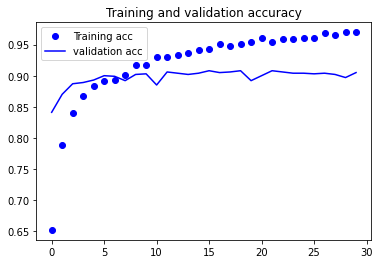

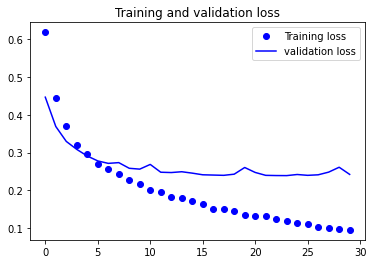

max/mean acc:  0.969999994635582 0.9198333276907603
max/mean val_acc:  0.9079999923706055 0.8976333265701929
max/mean loss:  0.6184193110466003 0.20203902136534452
max/mean val_loss:  0.44652549028396604 0.2666998878493905


In [17]:
acc= history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("max/mean acc: ", np.max(acc),np.mean(acc))
print("max/mean val_acc: ", np.max(val_acc),np.mean(val_acc))
print("max/mean loss: ", np.max(loss),np.mean(loss))
print("max/mean val_loss: ", np.max(val_loss),np.mean(val_loss))

특성 추출을 위한 두 번째 방법

데이터 증식을 활용한 ....

In [18]:
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


왜 30개가 되는지 이해했는데 의미는 이해하지 못함 

아마 vgg16 레이어 수랑 관련..이 맞았음 (왜 VGG16은 16이지)

conv_layers : 13개 텐서 두개씩 26개 + dense층거 4개 해서 30게

In [19]:
len(model.trainable_weights)

30

In [20]:
conv_base.trainable=False

conv_base의 가중치는 고정되고 두 Dense 층의 가중치만 훈력이 될 예정
tensor 는 4개 (가중치 행렬, 편향 벡터) 

In [21]:
len(model.trainable_weights)

4

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen= ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator=test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history=model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 9s - loss: 0.5658 - acc: 0.7165 - val_loss: 0.4230 - val_acc: 0.8310
Epoch 2/30
 - 8s - loss: 0.4047 - acc: 0.8440 - val_loss: 0.3359 - val_acc: 0.8670
Epoch 3/30
 - 9s - loss: 0.3487 - acc: 0.8555 - val_loss: 0.3006 - val_acc: 0.8790
Epoch 4/30
 - 8s - loss: 0.3216 - acc: 0.8660 - val_loss: 0.2809 - val_acc: 0.8890
Epoch 5/30
 - 9s - loss: 0.3035 - acc: 0.8690 - val_loss: 0.2724 - val_acc: 0.8920
Epoch 6/30
 - 8s - loss: 0.2905 - acc: 0.8805 - val_loss: 0.2589 - val_acc: 0.8940
Epoch 7/30
 - 9s - loss: 0.2696 - acc: 0.8960 - val_loss: 0.2551 - val_acc: 0.8990
Epoch 8/30
 - 8s - loss: 0.2757 - acc: 0.8850 - val_loss: 0.2508 - val_acc: 0.9000
Epoch 9/30
 - 8s - loss: 0.2555 - acc: 0.8950 - val_loss: 0.2630 - val_acc: 0.8890
Epoch 10/30
 - 8s - loss: 0.2497 - acc: 0.9020 - val_loss: 0.2429 - val_acc: 0.9070
Epoch 11/30
 - 8s - loss: 0.2410 - acc: 0.9050 - val_loss: 0.2445 - val_acc: 0.9010
E

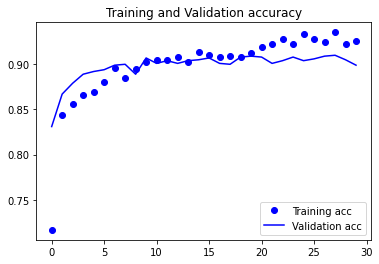

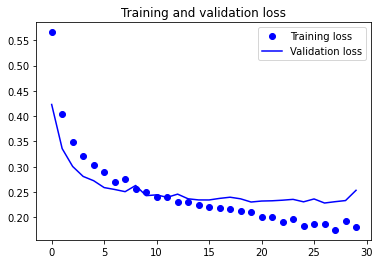

In [23]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
print("max/mean acc: ", np.max(acc),np.mean(acc))
print("max/mean val_acc: ", np.max(val_acc),np.mean(val_acc))
print("max/mean loss: ", np.max(loss),np.mean(loss))
print("max/mean val_loss: ", np.max(val_loss),np.mean(val_loss))

max/mean acc:  0.9354999929666519 0.8984166618883608
max/mean val_acc:  0.9099999976158142 0.8980333292086919
max/mean loss:  0.5657983052730561 0.2474301476509621
max/mean val_loss:  0.4230493628978729 0.2537015281853576


미세조정

동결모델 상위 층 몇 개를 동결 해제해 새로 연결한 층과 함께 훈련

최상위 두 세개의 층만 미세조정하는 것이 좋음

이유

1.하위 층들은 더 일반적이고 재사용 가능한 특성들 인코딩>> 미세조정 효과 감소
2. ㅇㄴ허ㅏㅣㅁㄹ;ㅣ

In [25]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [26]:
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
conv_base.trainable=False

set_trainable= False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if layer.name=='block5_conv2':
        set_trainable=True
    if layer.name=='block5_conv3':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable - False 

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=['acc'])

history=model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 9s 94ms/step - loss: 8.0444 - acc: 0.5005 - val_loss: 8.3331 - val_acc: 0.4830
Epoch 2/100
100/100 [==============================] - 8s 85ms/step - loss: 8.1396 - acc: 0.4950 - val_loss: 7.8979 - val_acc: 0.5100
Epoch 3/100
100/100 [==============================] - 8s 85ms/step - loss: 7.9785 - acc: 0.5050 - val_loss: 8.1235 - val_acc: 0.4960
Epoch 4/100
100/100 [==============================] - 8s 85ms/step - loss: 8.1155 - acc: 0.4965 - val_loss: 7.9785 - val_acc: 0.5050
Epoch 5/100
100/100 [==============================] - 8s 84ms/step - loss: 8.0993 - acc: 0.4975 - val_loss: 8.1719 - val_acc: 0.4930
Epoch 6/100
100/100 [==============================] - 8s 84ms/step - loss: 8.0268 - acc: 0.5020 - val_loss: 7.8817 - val_acc: 0.5110
Epoch 7/100
100/100 [==============================] - 8s 84ms/step - loss: 8.1396 - acc: 0.4950 - val_loss: 8.3653 - val_acc: 0.4810
Epoch 8/100
100/100 [==============================] - 8s 85ms

Epoch 62/100
100/100 [==============================] - 8s 84ms/step - loss: 8.0993 - acc: 0.4975 - val_loss: 8.2525 - val_acc: 0.4880
Epoch 63/100
100/100 [==============================] - 8s 84ms/step - loss: 7.9704 - acc: 0.5055 - val_loss: 7.9785 - val_acc: 0.5050
Epoch 64/100
100/100 [==============================] - 8s 85ms/step - loss: 8.0188 - acc: 0.5025 - val_loss: 8.1235 - val_acc: 0.4960
Epoch 65/100
100/100 [==============================] - 8s 84ms/step - loss: 8.0429 - acc: 0.5010 - val_loss: 7.9623 - val_acc: 0.5060
Epoch 66/100
100/100 [==============================] - 8s 84ms/step - loss: 8.0510 - acc: 0.5005 - val_loss: 8.1880 - val_acc: 0.4920
Epoch 67/100
100/100 [==============================] - 8s 85ms/step - loss: 8.1961 - acc: 0.4915 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 68/100
100/100 [==============================] - 8s 84ms/step - loss: 8.1155 - acc: 0.4965 - val_loss: 7.8173 - val_acc: 0.5150
Epoch 69/100
100/100 [==============================] -

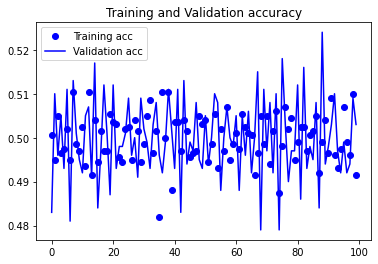

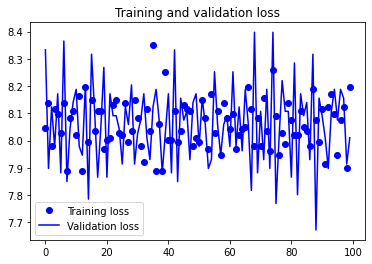

max/mean acc:  0.5105000039935113 0.49992000144124027
max/mean val_acc:  0.5240000015497208 0.49984000103771686
max/mean loss:  8.34917356967926 8.060271260885894
max/mean val_loss:  8.397527866363525 8.061626746416092


In [38]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("max/mean acc: ", np.max(acc),np.mean(acc))
print("max/mean val_acc: ", np.max(val_acc),np.mean(val_acc))
print("max/mean loss: ", np.max(loss),np.mean(loss))
print("max/mean val_loss: ", np.max(val_loss),np.mean(val_loss))

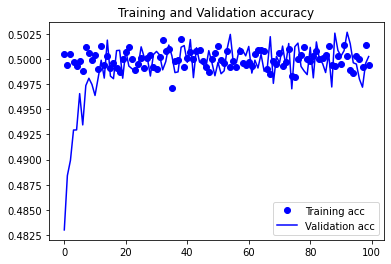

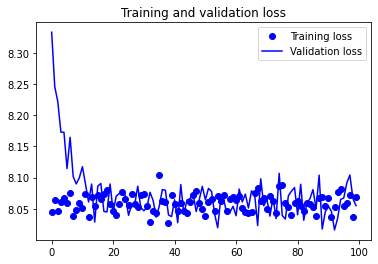

In [37]:
def smooth_curve(points,factor=0.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous =smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,smooth_curve(acc),'bo',label='Training acc')
plt.plot(epochs,smooth_curve(val_acc),'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,smooth_curve(loss),'bo',label='Training loss')
plt.plot(epochs,smooth_curve(val_loss),'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss,test_acc=model.evaluate_generator(test_generator,steps=50)
print('test acc: ', test_acc)

Found 1000 images belonging to 2 classes.
test acc:  0.49999999940395357


In [32]:
model.save('cats_and_dogs_small_4_2.h5')